In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import monai
import math
import numpy as np
import matplotlib.pyplot as plt
from timm.models.layers import DropPath, to_2tuple, trunc_normal_

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [3]:
data_img_path = r'D:\Datasets\Decathlon\Task03_Liver\imagesTr\liver_16.nii.gz'
data_label_path = r'D:\Datasets\Decathlon\Task03_Liver\labelsTr\liver_16.nii.gz'

data_file = {'image': data_img_path, 'label': data_label_path}

In [4]:
load_im = monai.transforms.LoadImaged(keys=['image', 'label'])
chan_f = monai.transforms.AddChanneld(keys=['image', "label"])
scale_intens = monai.transforms.ScaleIntensityRanged(keys='image', a_min=-21, a_max=189, b_min=0, b_max=1,clip=True)
to_t = monai.transforms.ToTensord(keys=["image", "label"])

data = to_t(scale_intens(chan_f(load_im(data_file))))

C:\ProgramData\Anaconda3\envs\CandidateNet\lib\site-packages\monai\utils\deprecate_utils.py:107: FutureWarning: <class 'monai.transforms.utility.array.AddChannel'>: Class `AddChannel` has been deprecated since version 0.8. please use MetaTensor data type and monai.transforms.EnsureChannelFirst instead.
  warn_deprecated(obj, msg, warning_category)


In [5]:
slice_max = 423

In [6]:
inputs = data['image'][:,:,:,slice_max].unsqueeze(0).to(device)
labels = data['label'][:,:,:,slice_max].unsqueeze(0).to(device)

In [7]:
slice_max

423

In [8]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [9]:
def visualize_data(im, lab):
    plt.figure()
    plt.imshow(im.squeeze().cpu().numpy(), cmap='gray')
    plt.imshow(lab.squeeze().cpu().numpy(), interpolation='none', alpha=0.33)

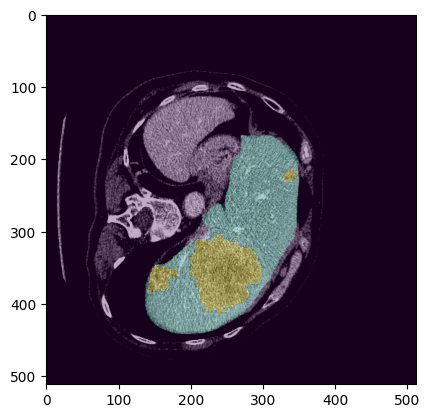

In [10]:
visualize_data(inputs, labels)

In [11]:
class RegularNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.net = nn.Sequential(nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
                        nn.BatchNorm2d(32),
                        nn.ReLU(),
                        nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
                        nn.BatchNorm2d(64),
                        nn.ReLU(),
                        nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
                        nn.BatchNorm2d(128),
                        nn.ReLU(),
                        nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
                        nn.BatchNorm2d(256),
                        nn.ReLU(),
                        nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
                        nn.BatchNorm2d(512),
                        nn.ReLU(),
                        nn.Conv2d(512, 3, kernel_size=3, stride=1, padding=1))
        
    def forward(self, x):
        return self.net(x)
        
        

In [12]:
class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

In [13]:
class Attention(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, qk_scale=None, attn_drop=0., proj_drop=0.):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x, attn

In [14]:
class Block(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., act_layer=nn.GELU, norm_layer=nn.LayerNorm):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.attn = Attention(
            dim, num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop)
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

    def forward(self, x, return_attention=False):
        y, attn = self.attn(self.norm1(x))
        if return_attention:
            return attn
        x = x + self.drop_path(y)
        x = x + self.drop_path(self.mlp(self.norm2(x)))
        return x

    def forward_fea_and_attn(self, x):
        y, attn = self.attn(self.norm1(x))
        x = x + self.drop_path(y)
        x = x + self.drop_path(self.mlp(self.norm2(x)))
        return x, attn

In [15]:
class PatchEmbed(nn.Module):
    """ Image to Patch Embedding
    """

    def __init__(self, img_size=224, patch_size=16, in_chans=3, embed_dim=768):
        super().__init__()
        num_patches = (img_size // patch_size) * (img_size // patch_size)
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = num_patches

        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        B, C, H, W = x.shape
        x = self.proj(x)
        Hp, Wp = x.shape[2], x.shape[3]
        x = x.flatten(2).transpose(1, 2)
        return x, (Hp, Wp)


In [2]:
def window_partition(x, window_size):
    """
    Args:
        x: (B, H, W, C)
        window_size (int): window size

    Returns:
        windows: (num_windows*B, window_size, window_size, C)
    """
    B, H, W, C = x.shape
    x = x.view(B, H // window_size, window_size, W // window_size, window_size, C)
    windows = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, window_size, window_size, C)
    return windows

In [ ]:
def window_reverse(windows, window_size, H, W):
    """
    Args:
        windows: (num_windows*B, window_size, window_size, C)
        window_size (int): Window size
        H (int): Height of image
        W (int): Width of image

    Returns:
        x: (B, H, W, C)
    """
    B = int(windows.shape[0] / (H * W / window_size / window_size))
    x = windows.view(B, H // window_size, W // window_size, window_size, window_size, -1)
    x = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(B, H, W, -1)
    return x

In [42]:
class LearnedMerge(nn.Module):
    def __init__(self, num_patches=1024, patch_merging=True):
        super().__init__()

        self.dim = 192
        self.depth = 4
        self.num_heads = 8
        self.out_dim = 3
        self.mlp_ratio = 4.0
        self.img_size = 512
        self.num_patches = num_patches
        self.patch_merging = patch_merging
        self.patch_merge_ratio = 0.5

        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches, self.dim))

        self.patch_size = int(self.img_size / math.sqrt(num_patches))
        print(self.patch_size)
        self.patch_emb = PatchEmbed(img_size=self.img_size, patch_size=self.patch_size, in_chans=1, embed_dim=self.dim)

        self.out = nn.Sequential(nn.ConvTranspose2d(self.dim, self.dim, kernel_size=2, stride=2),
                     nn.BatchNorm2d(self.dim),
                     nn.GELU(),
                     nn.ConvTranspose2d(self.dim, self.dim, kernel_size=2, stride=2),
                     nn.BatchNorm2d(self.dim),
                     nn.GELU(),
                     nn.ConvTranspose2d(self.dim, self.dim, kernel_size=2, stride=2),
                     nn.BatchNorm2d(self.dim),
                     nn.GELU(),
                     nn.ConvTranspose2d(self.dim, self.out_dim, kernel_size=2, stride=2))

        if self.patch_merging:
            self.scorer = nn.Sequential(nn.Linear(self.dim, 1),
                                        nn.GELU())

            self.downsample = nn.Sequential(nn.Conv2d(self.dim, self.dim, kernel_size=2, stride=2),
                                            nn.BatchNorm2d(self.dim),
                                            nn.GELU())
            self.upsample = nn.Sequential(nn.ConvTranspose2d(self.dim, self.dim, kernel_size=2, stride=2),
                                          nn.BatchNorm2d(self.dim),
                                          nn.GELU())


        
        self.blocks = nn.ModuleList([Block(dim=self.dim, num_heads=self.num_heads, mlp_ratio=self.mlp_ratio) for i in range(self.depth)])


    def merge_patches(self, x):
        B, N, C = x.shape

        x = x.view(B, N // 4, 2, 2, C)
        scores = self.scorer(x).squeeze(-1)

        _, topk_indices = scores.view(B, -1).topk(N // 8, dim=-1)

        selected_windows = x.view(B, -1, C)[torch.arange(B).unsqueeze(1), topk_indices]

        merged_tokens = self.downsample(selected_windows.permute(0, 3, 1, 2)).permute(0, 2, 3, 1)

        # Get the indices of the unmerged tokens
        unmerged_indices = torch.ones_like(scores, dtype=torch.bool)
        unmerged_indices.view(B, -1)[torch.arange(B).unsqueeze(1), topk_indices] = 0

        # Get the unmerged tokens by masking with the unmerged indices
        unmerged_tokens = x[unmerged_indices].view(B, -1, C)

        all_tokens = torch.cat([merged_tokens, unmerged_tokens], dim=1)

        return all_tokens

    def unmerge_patches(self, x):
        B, M, C = x.shape

        merged_tokens = x[:, -M // 4:, :]
        unmerged_tokens = x[:, :-M // 4, :]

        unmerged_tokens = unmerged_tokens.view(B, M // 16, 2, 2, C)
        unmerged_tokens = unmerged_tokens.view(B * (M // 16), 2, 2, C)

        unmerged_windows = self.upsample(merged_tokens.permute(0, 3, 1, 2)).permute(0, 2, 3, 1)

        unmerged_windows = unmerged_windows.view(B, M // 16, 4, 4, C)
        unmerged_windows = unmerged_windows.view(B, -1, C)


        
    def forward(self, x):
        B, C, H, W = x.shape

        x, (Hp, Wp) = self.patch_emb(x)
        x = x + self.pos_embed
        
        for i, blk in enumerate(self.blocks):
            x = blk(x)
            if i == 0 and self.patch_merging:
                x, merged_patches, reg_patches = self.merge_patches(x)

        if self.patch_merging:
            x = self.unmerge_patches(x, merged_patches, reg_patches, Hp, Wp)

        x = x.permute(0, 2, 1)
        x = x.view(-1, self.dim, self.img_size // self.patch_size, self.img_size // self.patch_size)
        x = self.out(x)

        return x
        
            
            
        

In [43]:
model = LearnedMerge()
model.to(device)
print(count_parameters(model))

16
2469507


Epoch: 49, Dice score: 0.6234816908836365, loss: 0.8850005865097046
Epoch: 99, Dice score: 0.7833694219589233, loss: 0.33075249195098877
Epoch: 149, Dice score: 0.8483754992485046, loss: 0.15440058708190918
Epoch: 199, Dice score: 0.8829337954521179, loss: 0.1030612662434578
Epoch: 249, Dice score: 0.9045768976211548, loss: 0.07607345283031464
Epoch: 299, Dice score: 0.9196367859840393, loss: 0.05777721852064133
Epoch: 349, Dice score: 0.9307514429092407, loss: 0.044976525008678436
Epoch: 399, Dice score: 0.9392408132553101, loss: 0.035769984126091
Epoch: 449, Dice score: 0.945923388004303, loss: 0.02913277968764305
Epoch: 499, Dice score: 0.9512968063354492, loss: 0.02419028803706169


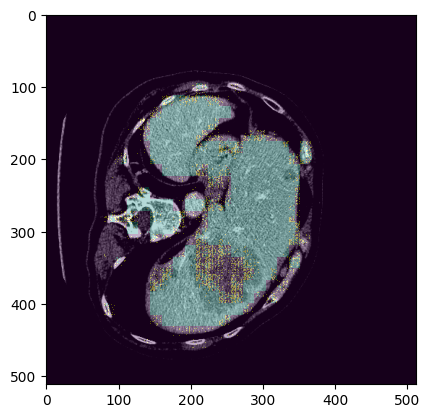

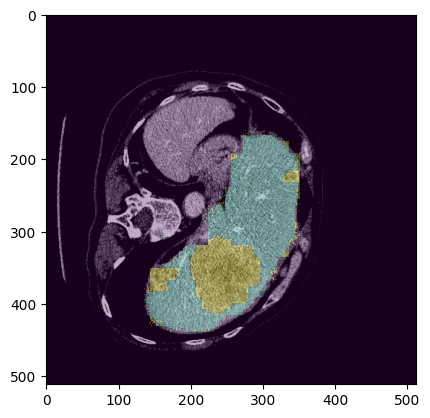

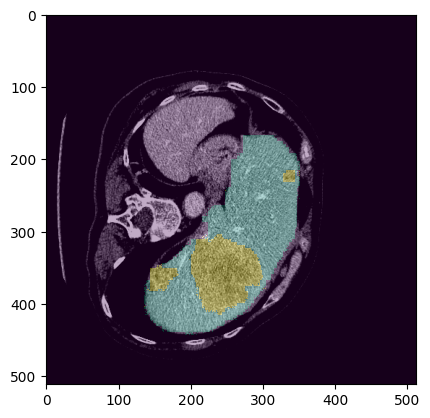

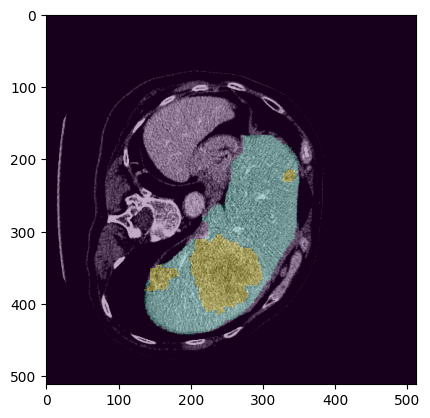

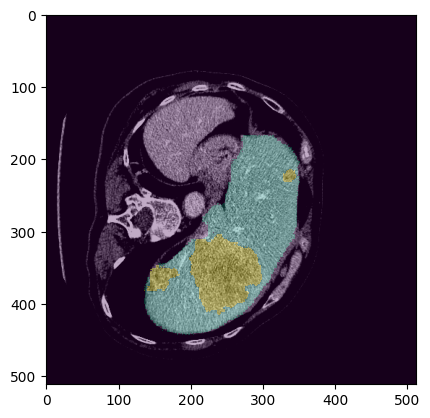

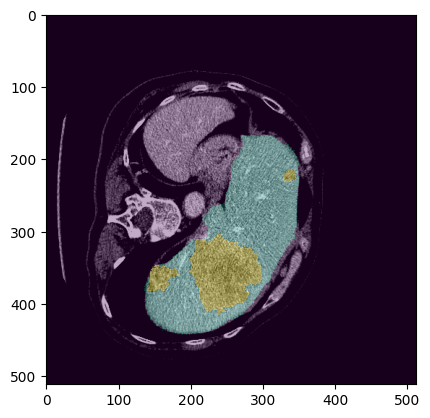

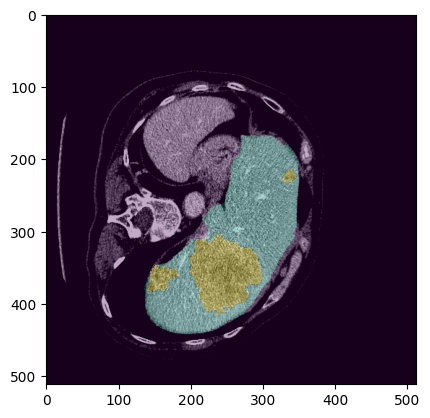

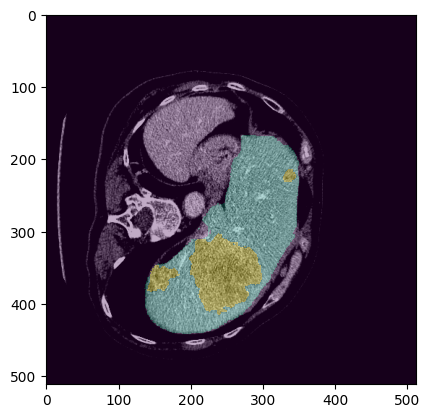

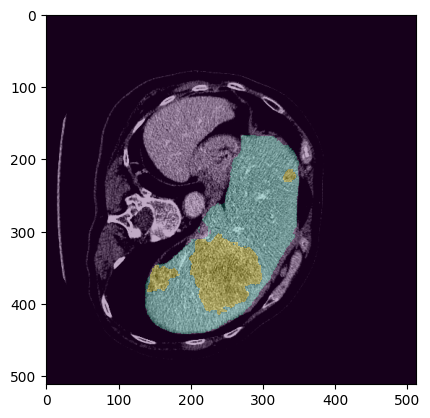

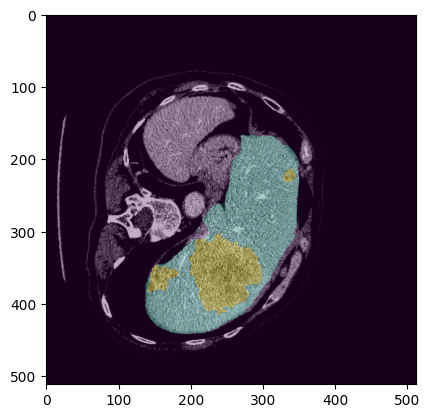

In [44]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
criterion = monai.losses.DiceCELoss(to_onehot_y=True, softmax=True, squared_pred=False)
post_label = monai.transforms.AsDiscrete(to_onehot=3)
post_pred = monai.transforms.AsDiscrete(argmax=True, to_onehot=3)
dice_metric = monai.metrics.DiceMetric(include_background=True, reduction="mean", get_not_nans=True)
epochs = 500
total_prints = 10
print_every_n_epochs = epochs // total_prints


for e in range(epochs):
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    

    if ((e + 1) % print_every_n_epochs) == 0:
        labels_convert = [post_label(labels[0])]
        output_convert = [post_pred(outputs[0])]
        dice_metric(y_pred=output_convert, y=labels_convert)
        dice_scores, dice_not_nans = dice_metric.aggregate()            
        pred = torch.argmax(outputs, dim=1)
        visualize_data(inputs, pred)
        print("Epoch: {}, Dice score: {}, loss: {}".format(e, dice_scores.item(), loss.item()))